Modeling gene expression with differential equations

constiutive gene expression -> constant, no regulation

reaction kinetics, rate * concentration 

In [1]:
import numpy as np
from scipy.integrate import odeint
import dnaplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interactive, interact
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Modeling the CRISPR TXTL system

In [3]:
txtl_crispr = pd.read_excel('supplemental_data/experimental_baseline.xlsx')

# clean in up a bit
def time_in_seconds(s):
    hour = s['Time'].hour
    minute = s['Time'].minute
    second = s['Time'].second
    
    total_seconds = hour * 3600 + minute * 60 + second
    return total_seconds
      
txtl_crispr['ts'] = txtl_crispr.apply(time_in_seconds, axis=1)
txtl_crispr.set_index('ts', inplace=True)
txtl_crispr = txtl_crispr.drop('Time', axis=1)


In [4]:
txtl_crispr.columns

txtl_crispr['g2_nM'] = 1000*txtl_crispr['g2']/544.0
txtl_crispr['g21_nM'] = 1000*txtl_crispr['g2.1']/544.0
txtl_crispr['NT_nM'] = 1000*txtl_crispr['NT']/544.0
txtl_crispr['NT1_nM'] = 1000*txtl_crispr['NT.1']/544.0


In [5]:
g2_group = ['g2_nM', 'g21_nM']
nt_group = ['NT_nM', 'NT1_nM']
control_group = ['cont1', 'cont1.1', 'cont2']

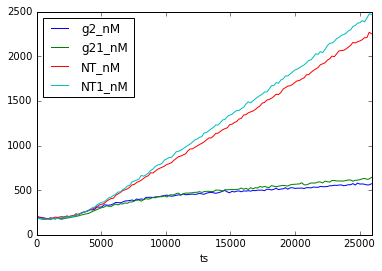

In [6]:
txtl_crispr[g2_group + nt_group ].plot()

# this was done with 1 nM of reporter
# this was done with 2 nM of guide

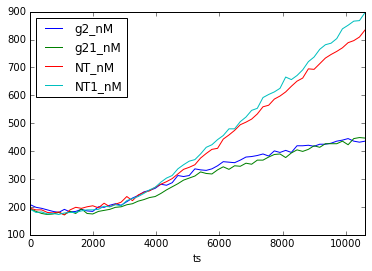

In [7]:
txtl_crispr[g2_group + nt_group ].iloc[0:60].plot()

In [8]:
# lets model the txtl systems!

# variables:
"""
all concentrations in µM

d_dcas9 = dCas9 dna
m_dcas9 = dCas9 mRNA transcript
p_dcas9 = dCas9 protein 

d_guide = guide dna
m_guide = guide rna transcript

p_rnp = dCas9 protein + guide RNA

d_gfp = gfp dna
d_gfp_bound = gfp dna bound to transcript
m_gfp = gfp mRNA transcript
p_gfpd = gfp protein, unfolded (immature)
p_gfpf = gfp protein, folded (glowing)

k_tx = rate of transcription (shared)
k_tl = rate of translation (shared)

b_rna = rate of rna degradation (shared) -> this is equal to our 1/tau_m
b_protein = rate of protein degradation (shared)
b_dna = rate of dna degradation (shared)

k_rnpform = rate of complex formation (E + S -> S), dC/dt = k_rnpform * [p_dcas9] * [m_guide]
k_targetbinding = rate of CRISPR binding

"""
# rate constants

k_tx = 0.5 # transcription kinetic
k_tx_guide = 0.5 # transcription of the guide plasmid

k_tl = 0.0003 # translation kinetic
k_mat = 0.001 # this is the maturation of the GFP protein

b_rna = 1.0/1000 # mRNA rate degradation
b_protein = 0.0 # protein degradation
b_dna = 0.0 # DNA degradation

k_rnpform = 0.000001 # best guess
k_targetbinding = 0.00001 # best guess


### Interactive simulation

In [9]:

t = np.arange(0, 3600*6, 60*3) # simulate over 10minutes, sampling every second

d_dcas9, m_dcas9, p_dcas9, p_rnp = initial_dcas9_conditions = [0, 0, 75, 0]

d_guide, m_guide = initial_guide_conditions = [0,0]

d_gfp, d_gfp_bound, m_gfp, p_gfpd, p_gfpf = initial_reporter_conditions = [0,0,0,0,0]

initial_conditions = initial_dcas9_conditions + initial_guide_conditions + initial_reporter_conditions

def crispr_txtl_system(y,t, new_target_binding):

    d_dcas9, m_dcas9, p_dcas9, p_rnp = y[0:4]
    d_guide, m_guide = y[4:6]
    d_gfp, d_gfp_bound, m_gfp, p_gfpd, p_gfpf = y[6:11]
    
    dt_d_dcas9 = - b_dna * d_dcas9
    # degradation only

    dt_m_dcas9 = k_tx * d_dcas9 - b_rna * m_dcas9    
    # degradation, transcription

    dt_p_dcas9 = k_tl * m_dcas9 - b_protein * p_dcas9 - k_rnpform * m_guide * p_dcas9    
    # degradation, translation    

    dt_p_rnp = + k_rnpform * m_guide * p_dcas9 - b_protein * p_rnp 
    # formation of RNP, degradation
    
    dt_d_guide = -b_dna * d_guide
    # degradation only
    
    dt_m_guide = k_tx_guide * d_guide - b_rna * m_guide - k_rnpform * m_guide * p_dcas9
    # transcription, degradation
    
    dt_d_gfp = -b_dna * d_gfp - new_target_binding * d_gfp * p_rnp 
    # degradation, binding
    
    dt_d_gfp_bound = new_target_binding * d_gfp * p_rnp 
    # binding only, assume no degradation here
    
    dt_m_gfp = k_tx * d_gfp  - b_rna * m_gfp
    # translation, degradation
    
    dt_p_gfpd = k_tl * m_gfp - b_protein * p_gfpd - k_mat * p_gfpd
    # translation, degradation, folding
    
    dt_p_gfpf = k_mat * p_gfpd - b_protein * p_gfpf
    
    return [dt_d_dcas9, dt_m_dcas9, dt_p_dcas9, dt_p_rnp,
            dt_d_guide, dt_m_guide,
            dt_d_gfp, dt_d_gfp_bound, dt_m_gfp, dt_p_gfpd, dt_p_gfpf]

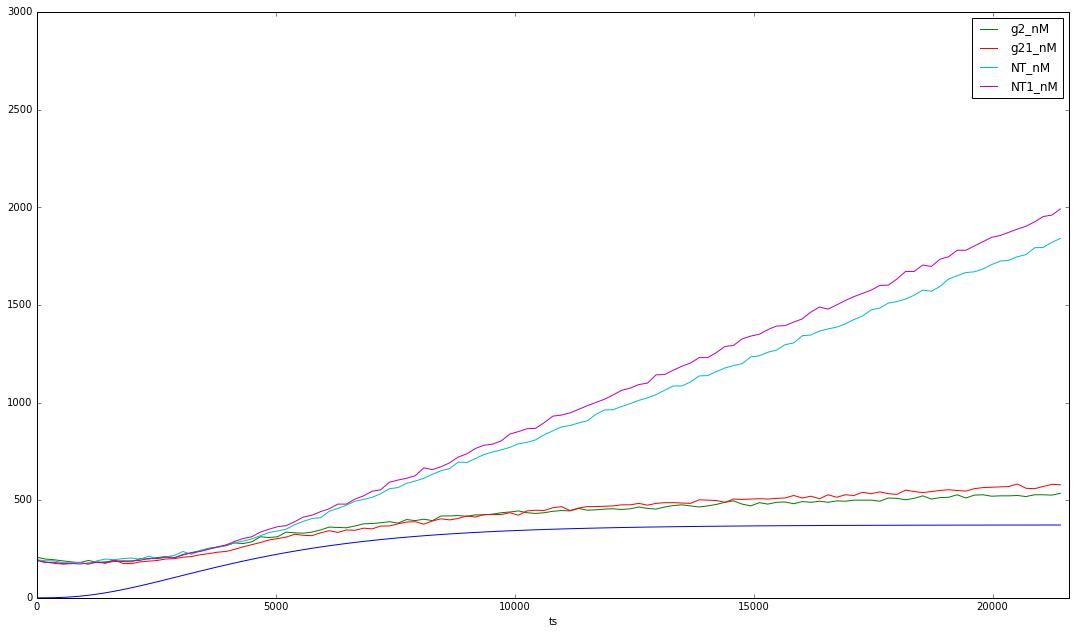

In [10]:

f,ax = plt.subplots(1,1, figsize=(12, 6))

def pltfig(dcas9_start=0, d_reporter_start=0.75, d_guide_start=2, m_guide_start=0,k_binding_start=10 ):

    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)

    d_dcas9, m_dcas9, p_dcas9, p_rnp = initial_dcas9_conditions = [0, 0, dcas9_start, 0]
    d_guide, m_guide = initial_guide_conditions = [d_guide_start,m_guide_start]
    d_gfp, d_gfp_bound, m_gfp, p_gfpd, p_gfpf = initial_reporter_conditions = [d_reporter_start,0,0,0,0]
    
    initial_conditions = initial_dcas9_conditions + initial_guide_conditions + initial_reporter_conditions
    
    # update the k's for rnp formation and binding
    
    k_targetbinding = 0.000001 * k_binding_start
    
    y = zip(*odeint(crispr_txtl_system, initial_conditions, t, (k_targetbinding,)))
    
    d_dcas9, m_dcas9, p_dcas9, p_rnp = y[0:4]    
    d_guide, m_guide = y[4:6]
    d_gfp, d_gfp_bound, m_gfp, p_gfpd, p_gfpf = y[6:11]

    ax = gca()
    
    ax.plot(t, p_gfpf, label='deGFP (folded)')

    txtl_crispr[g2_group + nt_group ].iloc[0:120].plot(ax=ax)
    ax.set_xlim((0, 3600*6))
    ax.set_ylim((0, 3000))

    plt.show()
    
# things I'd like to interact with
# starting concentration of p_dcas9
# starting concentration of guide plasmid dna
# starting concentration of guide RNA

interact(pltfig, 
         dcas9_start=(0,100, 0.1), 
         d_reporter_start=(0, 2, 0.1),          
         d_guide_start=(0, 2, 0.1),
         m_guide_start=(0, 5000, 0.1),         
         k_binding_start=(0, 20, 0.1)
        )
